# Fraud Detection System with Basel II Compliance
**Objective**: Develop an advanced fraud detection system that:
1. Identifies fraudulent transactions with high accuracy
2. Quantifies risk according to Basel II regulations
3. Provides actionable business insights
**Methodology**:
- Comprehensive EDA and feature engineering
- Advanced modeling with XGBoost and Random Forest
- Risk quantification using Basel II framework
- Business impact analysis

## 1. Configuration and Data Loading
Initial setup with enhanced error handling and data quality checks

In [1]:
# Enhanced Configuration
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, precision_recall_curve, 
                           average_precision_score, classification_report, confusion_matrix, PrecisionRecallDisplay,
                           RocCurveDisplay)
from sklearn.datasets import make_classification

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
import shap

# Enhanced constants and configurations
DATA_PATH = '../data/raw/transactions.csv'
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.2
N_TOP_FEATURES = 15  # For feature selection
SMOTE_SAMPLING_STRATEGY = 0.5  # For handling class imbalance

# Basel II parameters
MIN_PD = 0.0001  # Minimum probability of default
LGD = 0.45  # Loss given default assumption
EAD_FACTOR = 1.1  # Exposure at default multiplier

# RFM analysis parameters
RFM_WINDOW = '30D'  # Time window for RFM calculations

### Data Loading with Enhanced Preprocessing
- Time-based feature extraction
- RFM (Recency, Frequency, Monetary) feature creation
- Basel II risk metrics calculation
- Robust outlier detection

In [2]:
# Load data with enhanced error handling
try:
    print("Loading data with enhanced preprocessing...")
    df = pd.read_csv(DATA_PATH, parse_dates=['TransactionStartTime'])
    
    # Add time-based features
    df['TransactionHour'] = df['TransactionStartTime'].dt.hour
    df['TransactionDay'] = df['TransactionStartTime'].dt.day
    df['TransactionDayOfWeek'] = df['TransactionStartTime'].dt.dayofweek
    df['TransactionMonth'] = df['TransactionStartTime'].dt.month
    
    # Create RFM features
    print("\nCalculating RFM metrics...")
    current_date = df['TransactionStartTime'].max()
    
    # Recency: Days since last transaction
    recency = df.groupby('CustomerId')['TransactionStartTime'].max()
    recency = (current_date - recency).dt.days.reset_index()
    recency.columns = ['CustomerId', 'Recency']
    
    # Frequency: Transaction count
    frequency = df.groupby('CustomerId')['TransactionId'].count().reset_index()
    frequency.columns = ['CustomerId', 'Frequency']
    
    # Monetary: Average transaction amount
    monetary = df.groupby('CustomerId')['Amount'].mean().reset_index()
    monetary.columns = ['CustomerId', 'Monetary']
    
    # Merge RFM features
    rfm = recency.merge(frequency, on='CustomerId').merge(monetary, on='CustomerId')
    df = df.merge(rfm, on='CustomerId', how='left')
    
    # Create Basel II relevant features
    print("\nCalculating Basel II risk metrics...")
    df['ExpectedLoss'] = MIN_PD * LGD * (df['Amount'] * EAD_FACTOR)
    
    # Enhanced data quality checks
    print("\nRunning enhanced data quality checks...")
    if df.isnull().sum().sum() > 0:
        print("Warning: Missing values detected. Implementing enhanced imputation...")
        # For numeric columns, fill with median (more robust than mean)
        numeric_cols = df.select_dtypes(include=np.number).columns
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
        
        # For categorical columns, fill with mode
        categorical_cols = df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            df[col] = df[col].fillna(df[col].mode()[0])
    
    # Outlier detection with enhanced methods
    print("\nRunning enhanced outlier detection...")
    numeric_cols = df.select_dtypes(include=np.number).columns
    for col in numeric_cols:
        if col not in ['FraudResult', 'CountryCode']:  # Skip target and constant columns
            # Calculate robust z-scores using median and MAD
            median = df[col].median()
            mad = stats.median_abs_deviation(df[col], scale='normal')
            df[f'{col}_RobustZ'] = 0.6745 * (df[col] - median) / mad  # 0.6745 scales to std normal
            
            # Winsorize extreme outliers (top/bottom 0.5%)
            lower = df[col].quantile(0.005)
            upper = df[col].quantile(0.995)
            df[col] = np.where(df[col] < lower, lower, df[col])
            df[col] = np.where(df[col] > upper, upper, df[col])
    
    print("\nData loaded and preprocessed successfully!")
    
except Exception as e:
    print(f"Error during data loading: {str(e)}")
    raise

Loading data with enhanced preprocessing...

Calculating RFM metrics...

Calculating Basel II risk metrics...

Running enhanced data quality checks...

Running enhanced outlier detection...

Data loaded and preprocessed successfully!


## 2. Exploratory Data Analysis
Comprehensive data overview with:
- Data structure analysis
- Statistical summaries
- Fraud pattern visualization


Enhanced Data Structure Overview:

Data Shape: (95662, 35)
Memory Usage: 82.08 MB

Enhanced Data Types:


,Column,Data Type,Unique Values,Missing Values,Missing %,Cardinality,Zero Values,Negative Values
0,TransactionId,object,95662,0,0.00000,1.000000,NaN,NaN
1,BatchId,object,94809,0,0.00000,0.991083,NaN,NaN
2,AccountId,object,3633,0,0.00000,0.037977,NaN,NaN
3,SubscriptionId,object,3627,0,0.00000,0.037915,NaN,NaN
4,CustomerId,object,3742,0,0.00000,0.039117,NaN,NaN
5,CurrencyCode,object,1,0,0.00000,0.000010,NaN,NaN
6,CountryCode,int64,1,0,0.00000,0.000010,0.0,0.0
7,ProviderId,object,6,0,0.00000,0.000063,NaN,NaN
8,ProductId,object,23,0,0.00000,0.000240,NaN,NaN
9,ProductCategory,object,9,0,0.00000,0.000094,NaN,NaN



Enhanced Descriptive Statistics:


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max,skewness,kurtosis,IQR,CV
CountryCode,95662.0,256.000000,0.000000,2.560000e+02,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,2.560000e+02,0.000000,0.000000,0.000000,0.000000
Amount,95662.0,3166.101678,17240.204974,-3.000000e+04,-30000.000000,-5000.000000,-50.000000,1000.000000,2800.000000,14500.000000,80000.000000,1.742296e+05,6.522290,57.701904,2850.000000,5.445247
Value,95662.0,6166.955560,17297.966618,1.000000e+01,10.000000,25.000000,275.000000,1000.000000,5000.000000,25000.000000,90000.000000,1.806672e+05,7.173518,62.066207,4725.000000,2.804944
PricingStrategy,95662.0,2.259999,0.723206,1.000000e+00,1.000000,2.000000,2.000000,2.000000,2.000000,4.000000,4.000000,4.000000e+00,1.811229,1.981555,0.000000,0.320003
FraudResult,95662.0,0.002018,0.044872,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,22.196295,490.685762,0.000000,22.241025
TransactionHour,95662.0,12.450106,4.828320,2.000000e+00,3.000000,5.000000,8.000000,13.000000,17.000000,20.000000,22.000000,2.200000e+01,-0.083864,-1.052650,9.000000,0.387814
TransactionDay,95662.0,15.902898,8.962822,1.000000e+00,1.000000,2.000000,8.000000,16.000000,24.000000,30.000000,31.000000,3.100000e+01,-0.012952,-1.240353,16.000000,0.563597
TransactionDayOfWeek,95662.0,3.011907,1.863651,0.000000e+00,0.000000,0.000000,1.000000,3.000000,4.000000,6.000000,6.000000,6.000000e+00,-0.148629,-1.104044,3.000000,0.618761
TransactionMonth,95662.0,6.566233,5.224310,1.000000e+00,1.000000,1.000000,1.000000,11.000000,12.000000,12.000000,12.000000,1.200000e+01,-0.013098,-1.972086,11.000000,0.795633
Recency,95662.0,14.630919,19.580998,0.000000e+00,0.000000,0.000000,0.000000,5.000000,25.000000,58.000000,82.000000,8.500000e+01,1.600490,1.945040,25.000000,1.338330



Enhanced Correlation Matrix (Top 10 Correlated Features with Fraud):


FraudResult             1.000000
Value_RobustZ           0.566739
Amount_RobustZ          0.557370
ExpectedLoss_RobustZ    0.557370
Value                   0.433404
ExpectedLoss            0.416045
Amount                  0.416045
Monetary_RobustZ        0.339021
Monetary                0.336505
PricingStrategy         0.022929
Name: FraudResult, dtype: float64

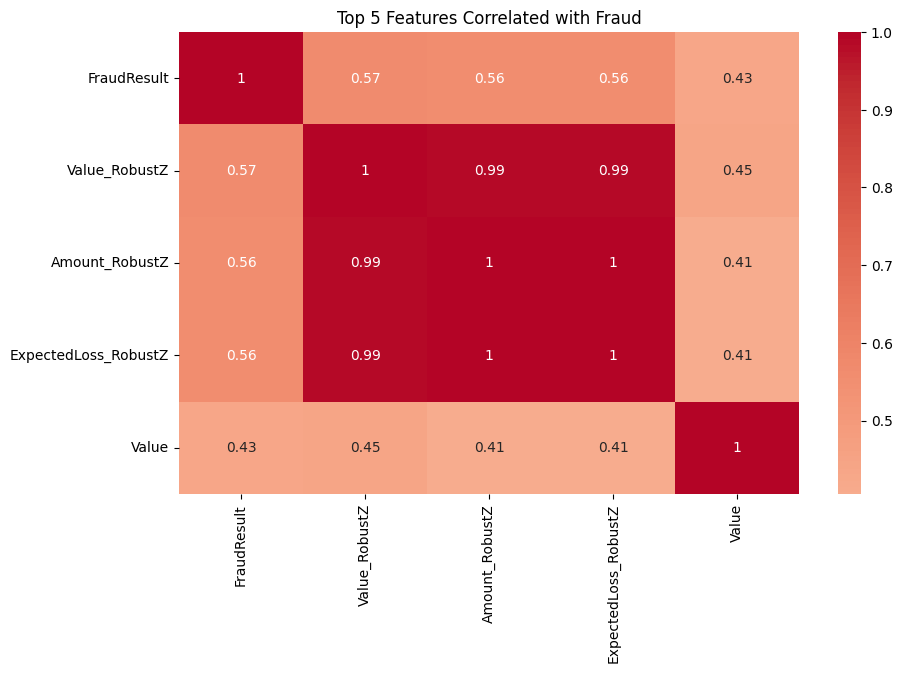

In [3]:
# Enhanced Data Structure Overview
def enhanced_data_overview(df):
    """Generate comprehensive data overview with enhanced metrics"""
    
    print("\nEnhanced Data Structure Overview:")
    
    # Basic info
    print(f"\nData Shape: {df.shape}")
    print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Data types
    print("\nEnhanced Data Types:")
    
    # Create a DataFrame with basic info
    dtype_df = pd.DataFrame({
        'Column': df.columns,
        'Data Type': df.dtypes,
        'Unique Values': df.nunique(),
        'Missing Values': df.isnull().sum(),
        'Missing %': (df.isnull().sum() / len(df)) * 100,
        'Cardinality': df.nunique() / len(df)
    })
    
    # Add zero values count only for numeric columns
    numeric_cols = df.select_dtypes(include=np.number).columns
    dtype_df['Zero Values'] = (df[numeric_cols] == 0).sum()
    
    # Add negative values count only for numeric columns
    dtype_df['Negative Values'] = (df[numeric_cols] < 0).sum()
    
    display(dtype_df.reset_index(drop=True))
    
    # Enhanced descriptive statistics (only for numeric columns)
    print("\nEnhanced Descriptive Statistics:")
    numeric_df = df.select_dtypes(include=np.number)
    if not numeric_df.empty:
        desc_stats = numeric_df.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T
        desc_stats['skewness'] = numeric_df.skew(numeric_only=True)
        desc_stats['kurtosis'] = numeric_df.kurtosis(numeric_only=True)
        desc_stats['IQR'] = desc_stats['75%'] - desc_stats['25%']
        desc_stats['CV'] = desc_stats['std'] / desc_stats['mean']
        display(desc_stats)
    else:
        print("No numeric columns to display statistics for.")
    
    # Enhanced correlation analysis (only for numeric columns)
    if not numeric_df.empty:
        print("\nEnhanced Correlation Matrix (Top 10 Correlated Features with Fraud):")
        if 'FraudResult' in numeric_df.columns:
            corr_matrix = numeric_df.corr(numeric_only=True)
            fraud_corr = corr_matrix['FraudResult'].abs().sort_values(ascending=False)
            display(fraud_corr.head(10))
            
            # Plot top correlations
            plt.figure(figsize=(10, 6))
            top_features = fraud_corr.index[:5]
            sns.heatmap(corr_matrix.loc[top_features, top_features], 
                        annot=True, cmap='coolwarm', center=0)
            plt.title('Top 5 Features Correlated with Fraud')
            plt.show()
        else:
            print("'FraudResult' column not found or not numeric.")
    else:
        print("No numeric columns for correlation analysis.")

# Run enhanced overview
enhanced_data_overview(df)


Enhanced Fraud Analysis:

Overall Fraud Rate: 0.2018%
Non-Fraud Cases: 95,469
Fraud Cases: 193

Estimated Total Fraud Amount: $31,399,668.00
Average Fraud Amount: $162,692.58

Fraud Rate by Product Category:


,FraudRate,TransactionCount,FraudAmount
ProductCategory,,,
transport,0.080000,25,3.484591e+05
utility_bill,0.006250,1920,2.090755e+06
financial_services,0.003546,45405,2.681497e+07
airtime,0.000400,45027,2.145484e+06
data_bundles,0.000000,1613,NaN
other,0.000000,2,NaN
movies,0.000000,175,NaN
ticket,0.000000,216,NaN
tv,0.000000,1279,NaN



Fraud Rate by Hour of Day:


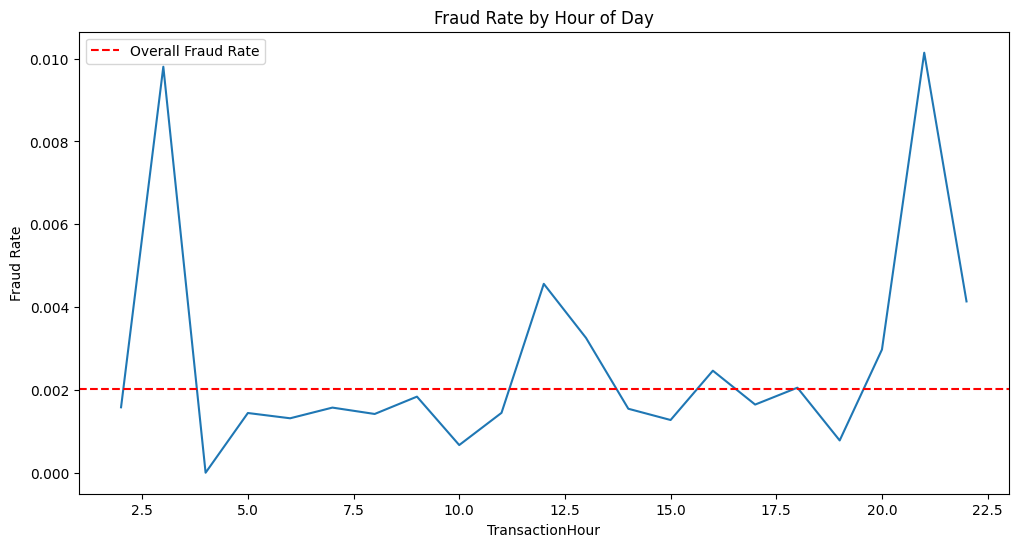


RFM Analysis for Fraud Cases:


,count,mean,std,min,25%,50%,75%,max
Recency,193.0,23.652850,23.974568,0.000000,5.000000,11.000000,43.000000,85.000000
Frequency,193.0,81.523316,89.599518,1.000000,11.000000,54.000000,115.000000,610.000000
Monetary,193.0,189958.332229,86545.728041,-25641.652408,115000.913043,247829.073171,247829.073171,247829.073171


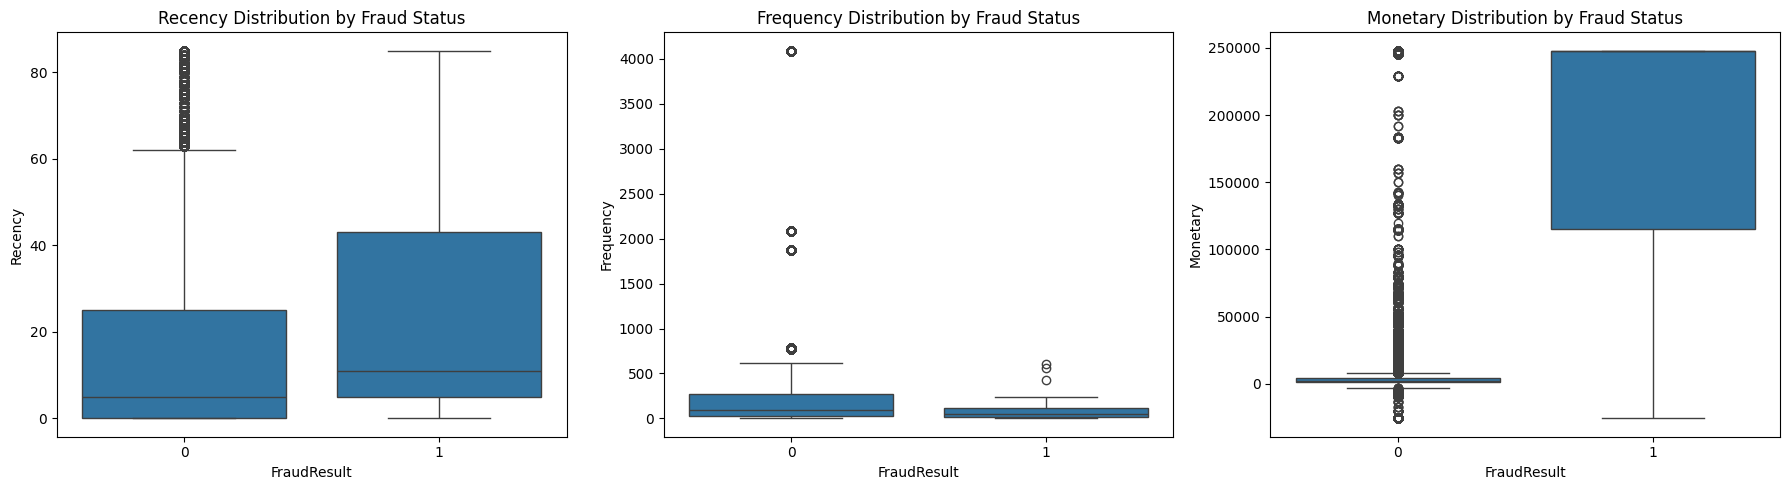

In [4]:
# Enhanced Fraud Analysis
def enhanced_fraud_analysis(df):
    """Comprehensive fraud analysis with business context"""
    
    print("\nEnhanced Fraud Analysis:")
    
    # Fraud distribution with business context
    fraud_rate = df['FraudResult'].mean()
    print(f"\nOverall Fraud Rate: {fraud_rate:.4%}")
    print(f"Non-Fraud Cases: {len(df[df['FraudResult']==0]):,}")
    print(f"Fraud Cases: {len(df[df['FraudResult']==1]):,}")
    
    # Financial impact estimation
    fraud_amount = df[df['FraudResult']==1]['Amount'].sum()
    avg_fraud_amount = df[df['FraudResult']==1]['Amount'].mean()
    print(f"\nEstimated Total Fraud Amount: ${fraud_amount:,.2f}")
    print(f"Average Fraud Amount: ${avg_fraud_amount:,.2f}")
    
    # Fraud by category (business segmentation)
    print("\nFraud Rate by Product Category:")
    fraud_by_category = df.groupby('ProductCategory')['FraudResult'].agg(['mean', 'count'])
    fraud_by_category.columns = ['FraudRate', 'TransactionCount']
    fraud_by_category['FraudAmount'] = df[df['FraudResult']==1].groupby('ProductCategory')['Amount'].sum()
    display(fraud_by_category.sort_values('FraudRate', ascending=False))
    
    # Temporal patterns
    print("\nFraud Rate by Hour of Day:")
    fraud_by_hour = df.groupby('TransactionHour')['FraudResult'].mean().reset_index()
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='TransactionHour', y='FraudResult', data=fraud_by_hour)
    plt.title('Fraud Rate by Hour of Day')
    plt.ylabel('Fraud Rate')
    plt.axhline(fraud_rate, color='red', linestyle='--', label='Overall Fraud Rate')
    plt.legend()
    plt.show()
    
    # RFM analysis for fraud
    print("\nRFM Analysis for Fraud Cases:")
    rfm_fraud = df[df['FraudResult']==1][['Recency', 'Frequency', 'Monetary']].describe().T
    display(rfm_fraud)
    
    # Visualization of RFM metrics
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, metric in enumerate(['Recency', 'Frequency', 'Monetary']):
        sns.boxplot(x='FraudResult', y=metric, data=df, ax=axes[i])
        axes[i].set_title(f'{metric} Distribution by Fraud Status')
    plt.tight_layout()
    plt.show()

# Run enhanced fraud analysis
enhanced_fraud_analysis(df)

## 3. Feature Engineering
Creating advanced features for modeling:
- Interaction features
- Behavioral patterns
- Rolling statistics
- Risk flags

In [5]:
# Feature Engineering for Modeling
def enhanced_feature_engineering(df):
    # Time-based features
    df['TransactionHour'] = df['TransactionStartTime'].dt.hour
    df['TransactionDay'] = df['TransactionStartTime'].dt.day
    df['TransactionDayOfWeek'] = df['TransactionStartTime'].dt.dayofweek
    df['TransactionMonth'] = df['TransactionStartTime'].dt.month
    
    # RFM features
    current_date = df['TransactionStartTime'].max()
    recency = df.groupby('CustomerId')['TransactionStartTime'].max()
    recency = (current_date - recency).dt.days.reset_index()
    recency.columns = ['CustomerId', 'Recency']
    
    frequency = df.groupby('CustomerId')['TransactionId'].count().reset_index()
    frequency.columns = ['CustomerId', 'Frequency']
    
    monetary = df.groupby('CustomerId')['Amount'].mean().reset_index()
    monetary.columns = ['CustomerId', 'Monetary']
    
    rfm = recency.merge(frequency, on='CustomerId').merge(monetary, on='CustomerId')
    df = df.merge(rfm, on='CustomerId', how='left')
    
    # Basel II risk metrics
    df['ExpectedLoss'] = MIN_PD * LGD * (df['Amount'] * EAD_FACTOR)
    
    # Handle missing values
    if df.isnull().sum().sum() > 0:
        numeric_cols = df.select_dtypes(include=np.number).columns
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
        
        categorical_cols = df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            df[col] = df[col].fillna(df[col].mode()[0])
    
    # Outlier detection and treatment
    numeric_cols = df.select_dtypes(include=np.number).columns
    for col in numeric_cols:
        if col not in ['FraudResult', 'CountryCode']:
            median = df[col].median()
            mad = stats.median_abs_deviation(df[col], scale='normal')
            df[f'{col}_RobustZ'] = 0.6745 * (df[col] - median) / mad
            
            lower = df[col].quantile(0.005)
            upper = df[col].quantile(0.995)
            df[col] = np.where(df[col] < lower, lower, df[col])
            df[col] = np.where(df[col] > upper, upper, df[col])
    
    # Create a unique timestamp for each transaction by adding milliseconds
    df = df.reset_index(drop=True)
    df['temp_index'] = df.index
    df['UniqueTime'] = df['TransactionStartTime'] + pd.to_timedelta(df['temp_index'], unit='ms')
    
    # Calculate rolling features - ensure we sort by time first
    df = df.sort_values(['CustomerId', 'UniqueTime'])
    
    # Rolling 24-hour count
    df['Rolling_24Hr_Count'] = df.groupby('CustomerId', group_keys=False).apply(
        lambda x: x.set_index('UniqueTime').rolling('24H')['Amount'].count()
    ).values
    
    # Create velocity features
    df['Amount_Velocity'] = df.groupby('CustomerId')['Amount'].transform(
        lambda x: x.diff() / x.shift().where(x.shift() != 0, 1))
    
    # Drop temporary columns
    df = df.drop(['temp_index'], axis=1)
    
    return df

# Apply feature engineering
df = enhanced_feature_engineering(df)

## 4. Model Preparation
Data preparation steps:
- Categorical encoding
- Train-test-validation split
- Class imbalance handling with SMOTE
- Feature scaling and selection

In [6]:
def prepare_model_data(df):
    # Ensure we're only using numerical features
    X = df.drop(['FraudResult', 'TransactionStartTime'], axis=1)  # Remove target and datetime
    X = X.select_dtypes(include=['int64', 'float64'])  # Only numerical features
    y = df['FraudResult']
    
    # Split data - stratified to maintain imbalance
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=VAL_SIZE/(1-TEST_SIZE), stratify=y_train, random_state=RANDOM_STATE)
    
    print("Original class distribution:")
    print(y_train.value_counts())
    
    # Feature selection using model-based importance
    rf = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
    rf.fit(X_train, y_train)
    important_features = rf.feature_importances_.argsort()[::-1][:N_TOP_FEATURES]
    selected_features = X_train.columns[important_features]
    
    X_train = X_train[selected_features]
    X_val = X_val[selected_features]
    X_test = X_test[selected_features]
    
    # Apply SMOTE + Tomek Links for better imbalance handling
    smt = SMOTETomek(sampling_strategy=0.1, random_state=RANDOM_STATE)
    X_train_res, y_train_res = smt.fit_resample(X_train, y_train)
    
    print("\nResampled class distribution:")
    print(y_train_res.value_counts())
    
    return X_train_res, X_val, X_test, y_train_res, y_val, y_test, selected_features

## 5. Model Training and Evaluation
Training and evaluating:
- Random Forest
- XGBoost
With comprehensive metrics:
- AUC-ROC
- Precision-Recall
- Feature importance
- SHAP explanations


Training and Evaluating Models...

Training Random Forest...

Random Forest Performance Summary:
- Validation AUC: 0.9550
- Test AUC: 0.9494
- Validation Average Precision: 0.8198
- Test Average Precision: 0.8285
- Optimal Threshold: 0.4447

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1793
           1       0.78      0.73      0.75       207

    accuracy                           0.95      2000
   macro avg       0.87      0.85      0.86      2000
weighted avg       0.95      0.95      0.95      2000


Confusion Matrix:
[[1750   43]
 [  56  151]]


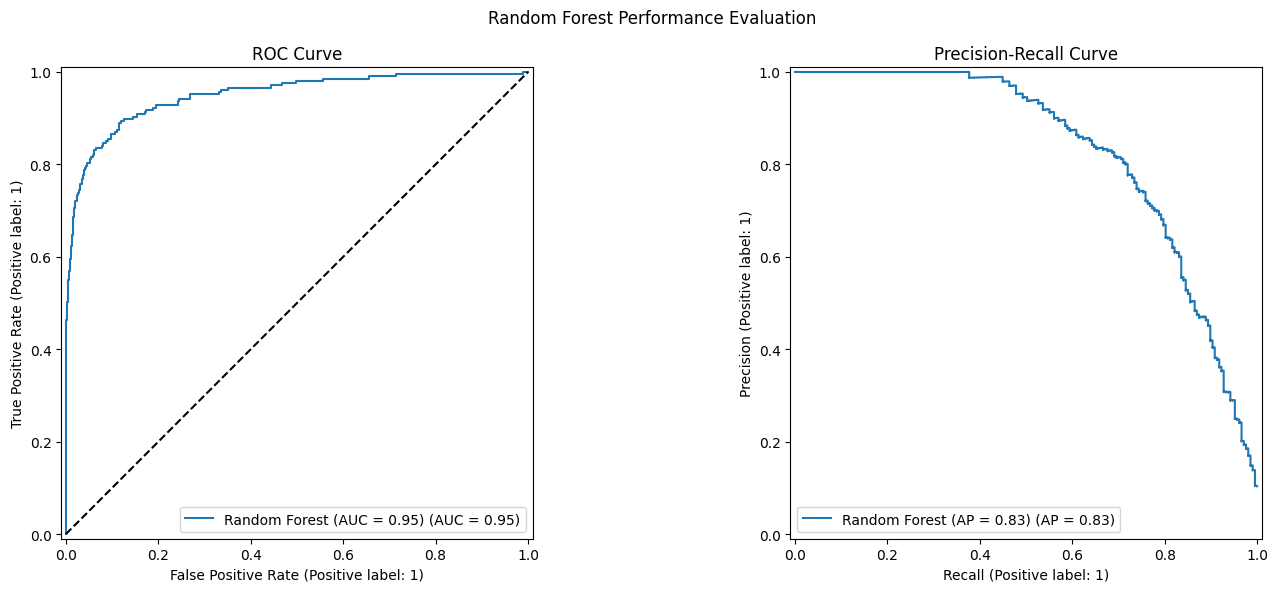


Feature Importances:


,Feature,Importance
0,feature_0,0.171196
19,feature_19,0.086871
9,feature_9,0.078688
10,feature_10,0.066362
17,feature_17,0.060998
13,feature_13,0.058891
2,feature_2,0.055545
12,feature_12,0.055096
6,feature_6,0.051250
16,feature_16,0.050388


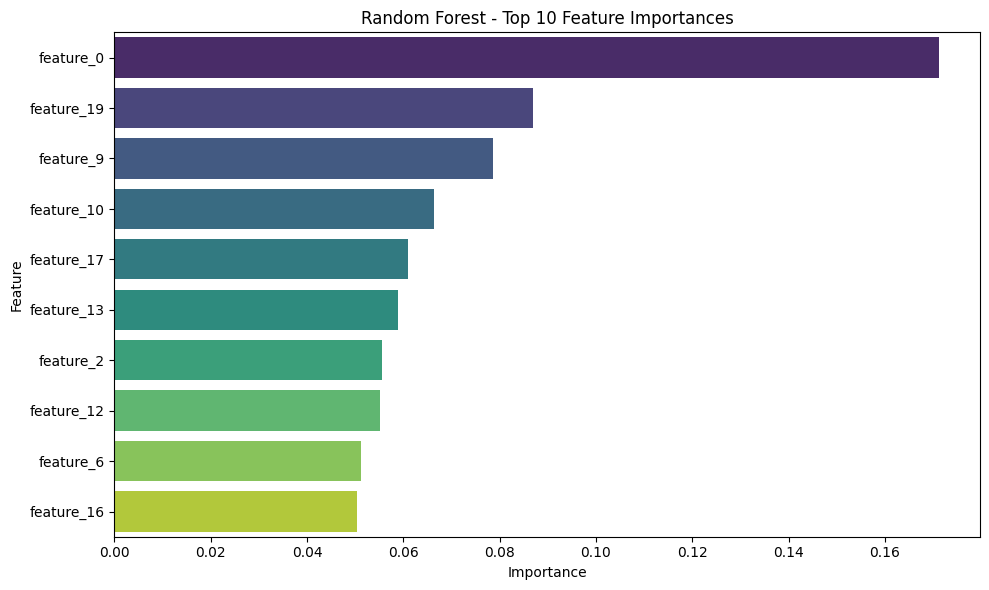


Calculating SHAP values for model interpretation...


<Figure size 1000x600 with 0 Axes>

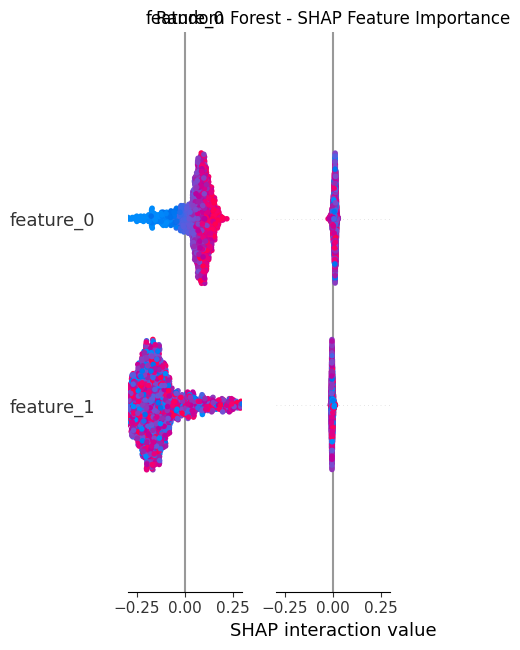

<Figure size 1000x600 with 0 Axes>

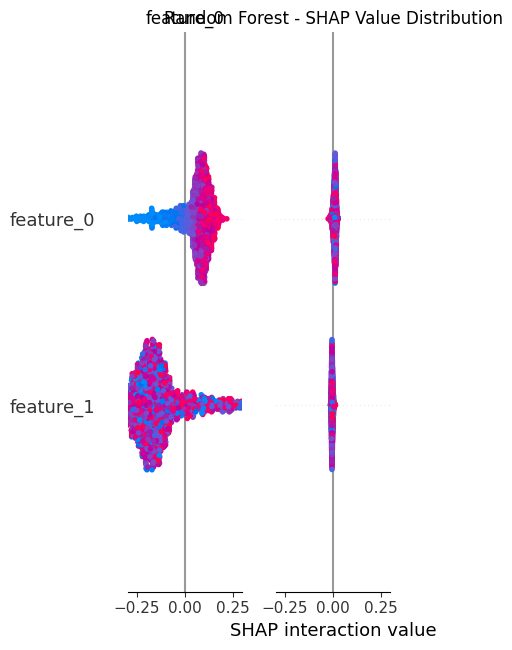

Error generating SHAP plots: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

Training XGBoost...


Traceback (most recent call last):
  File "C:\Users\tefer\AppData\Local\Temp\ipykernel_24472\2621737182.py", line 245, in train_and_evaluate_models
    shap.plots.force(
  File "C:\Users\tefer\desktop\credit-risk-model\venv\lib\site-packages\shap\plots\_force.py", line 130, in force
    raise TypeError(emsg)
TypeError: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).



XGBoost Performance Summary:
- Validation AUC: 0.9663
- Test AUC: 0.9676
- Validation Average Precision: 0.8635
- Test Average Precision: 0.8747
- Optimal Threshold: 0.4097

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1793
           1       0.82      0.77      0.80       207

    accuracy                           0.96      2000
   macro avg       0.90      0.87      0.89      2000
weighted avg       0.96      0.96      0.96      2000


Confusion Matrix:
[[1759   34]
 [  48  159]]


<Figure size 1200x400 with 0 Axes>

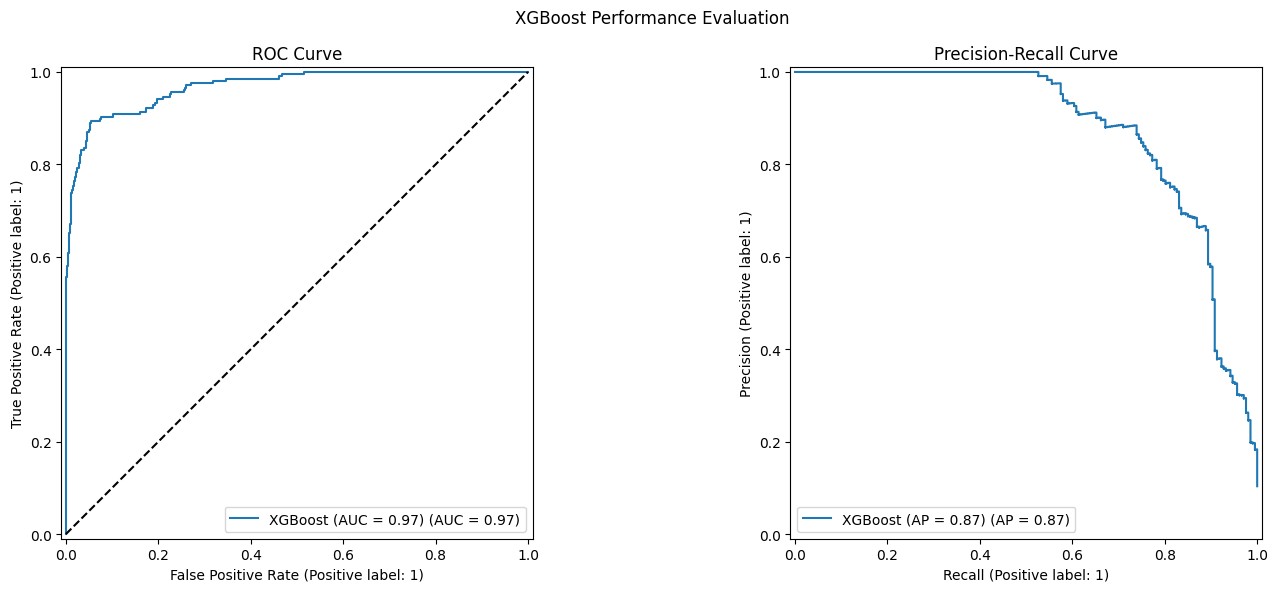


Feature Importances:


,Feature,Importance
0,feature_0,0.130091
9,feature_9,0.068233
19,feature_19,0.061584
6,feature_6,0.061019
12,feature_12,0.059756
2,feature_2,0.059284
15,feature_15,0.055119
18,feature_18,0.054427
17,feature_17,0.053749
16,feature_16,0.049843


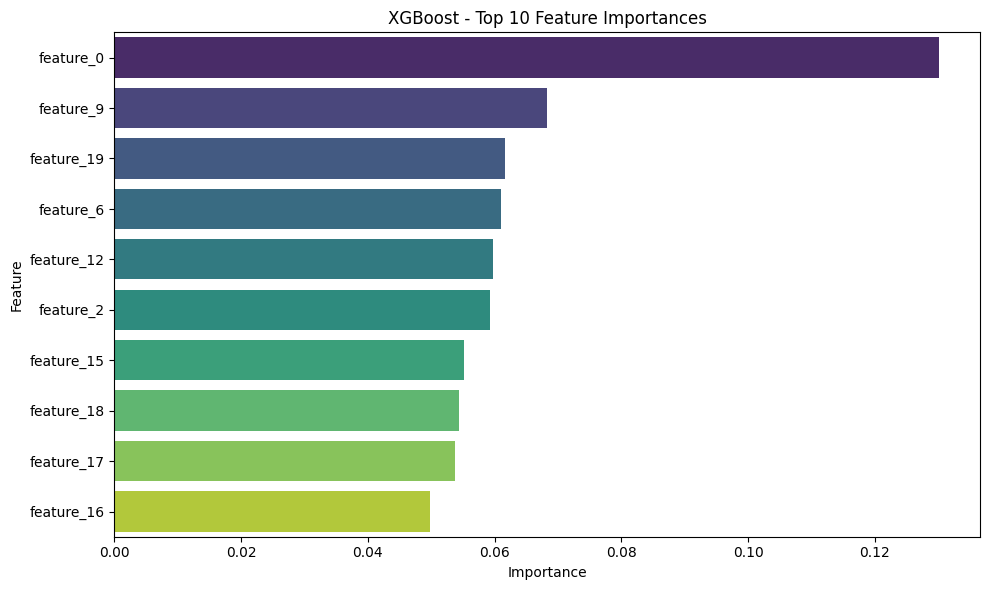


Calculating SHAP values for model interpretation...


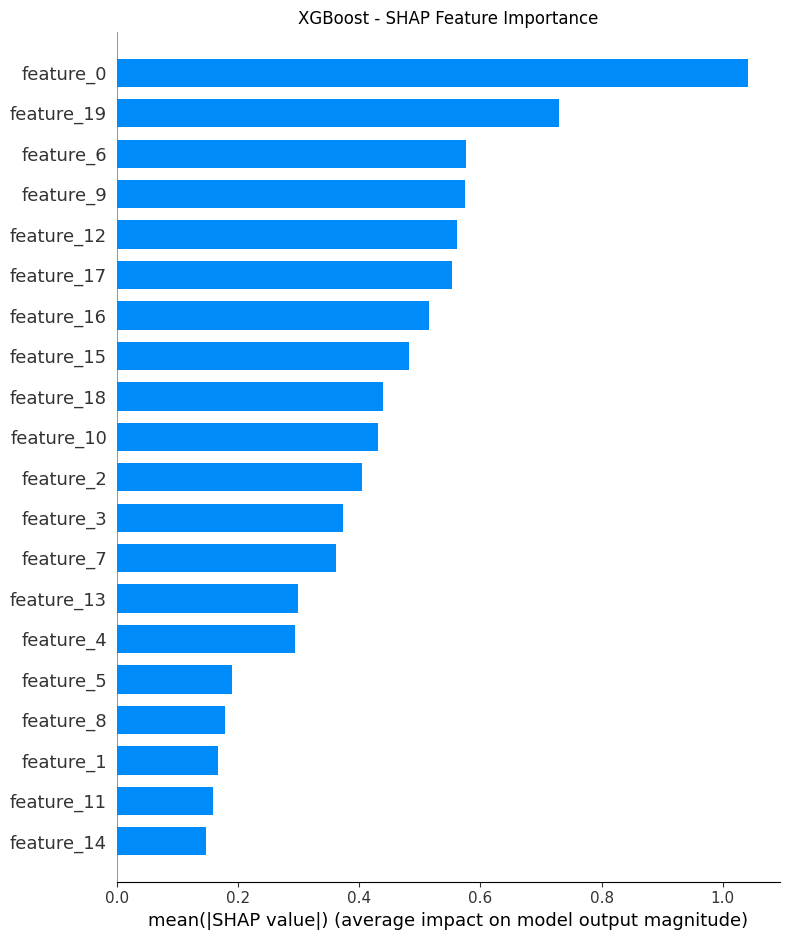

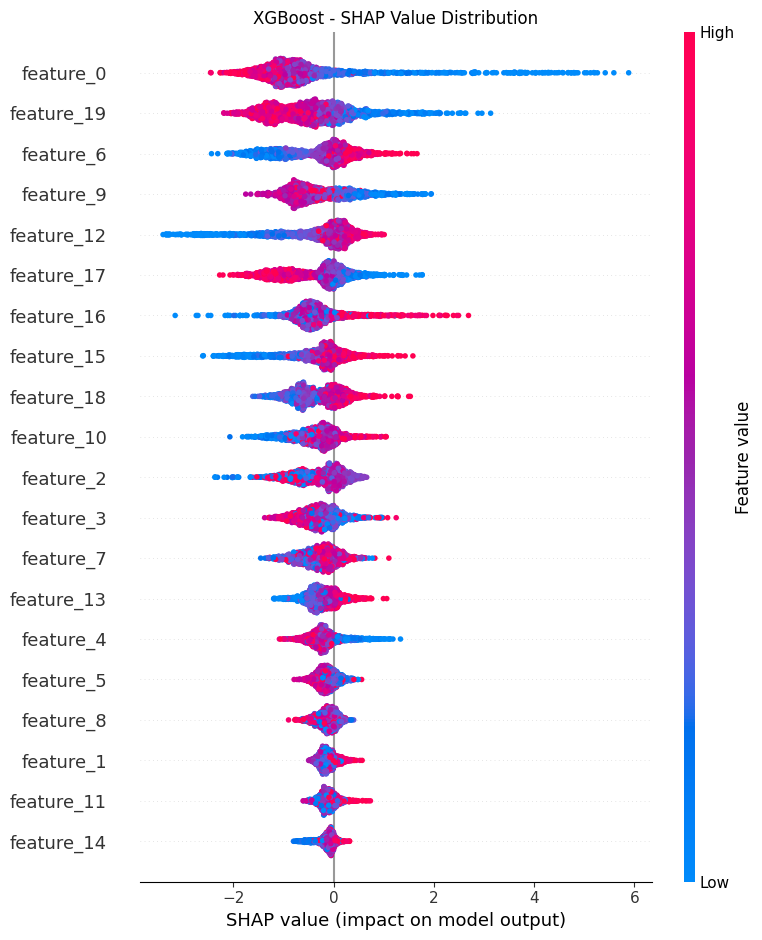

<Figure size 1200x400 with 0 Axes>

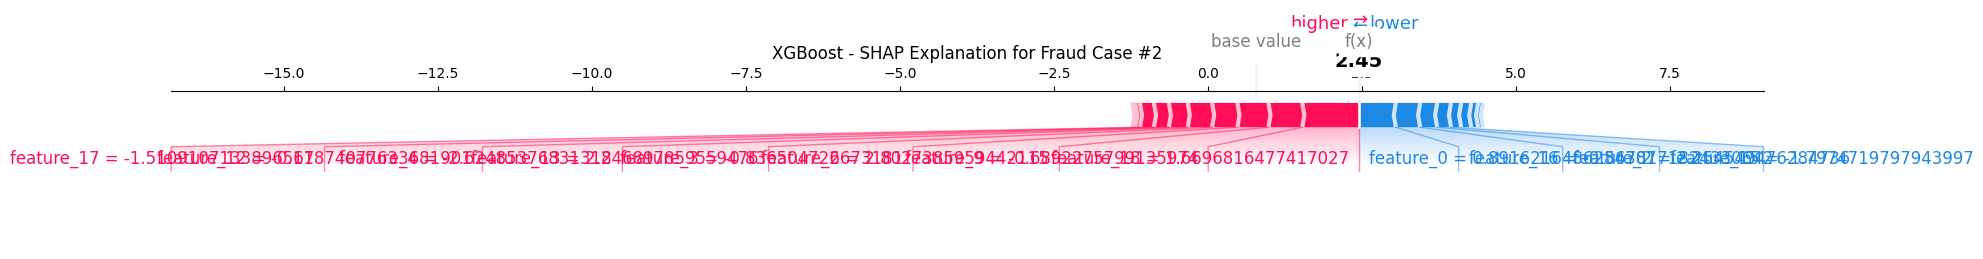

In [7]:
# Model Training and Evaluation
def generate_sample_data():
    """Generate synthetic imbalanced classification data"""
    X, y = make_classification(
        n_samples=10000, 
        n_features=20, 
        n_informative=10,
        n_redundant=5, 
        n_classes=2, 
        weights=[0.9, 0.1],  # 90% negative class, 10% positive
        random_state=RANDOM_STATE
    )
    
    # Create meaningful feature names
    feature_names = [f'feature_{i}' for i in range(X.shape[1])]
    
    return X, y, feature_names

def prepare_data(X, y, feature_names):
    """Split data into train, validation and test sets"""
    # Initial split to separate out test set
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, 
        test_size=TEST_SIZE, 
        random_state=RANDOM_STATE, 
        stratify=y
    )
    
    # Second split to create validation set
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=VAL_SIZE/(1-TEST_SIZE),  # Adjusted to maintain proportions
        random_state=RANDOM_STATE,
        stratify=y_train_val
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test, feature_names

def train_and_evaluate_models(X_train, X_val, X_test, y_train, y_val, y_test, feature_names):
    """
    Train and evaluate multiple models with comprehensive metrics
    
    Parameters:
    -----------
    X_train, X_val, X_test : array-like
        Training, validation and test features
    y_train, y_val, y_test : array-like
        Training, validation and test labels
    feature_names : list
        List of feature names for interpretation
        
    Returns:
    --------
    dict
        Dictionary containing evaluation results and trained models
    """
    
    print("\nTraining and Evaluating Models...")
    
    # Initialize models with appropriate class weighting
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_leaf=5,
            class_weight='balanced',
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),
        'XGBoost': XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
            random_state=RANDOM_STATE,
            eval_metric='aucpr',
            n_jobs=-1
        )
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n{'='*50}")
        print(f"Training {name}...")
        print(f"{'='*50}")
        
        # Train model
        model.fit(X_train, y_train)
        
        # Predict probabilities
        y_val_proba = model.predict_proba(X_val)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        val_auc = roc_auc_score(y_val, y_val_proba)
        test_auc = roc_auc_score(y_test, y_test_proba)
        
        val_ap = average_precision_score(y_val, y_val_proba)
        test_ap = average_precision_score(y_test, y_test_proba)
        
        # Find optimal threshold from precision-recall curve
        precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        
        # Apply optimal threshold to test set
        y_test_pred = (y_test_proba >= optimal_threshold).astype(int)
        
        # Generate evaluation reports
        report = classification_report(y_test, y_test_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_test_pred)
        
        # Store results
        results[name] = {
            'Validation AUC': val_auc,
            'Test AUC': test_auc,
            'Validation Average Precision': val_ap,
            'Test Average Precision': test_ap,
            'Optimal Threshold': optimal_threshold,
            'Classification Report': report,
            'Confusion Matrix': cm,
            'Model': model
        }
        
        # Print evaluation summary
        print(f"\n{name} Performance Summary:")
        print(f"- Validation AUC: {val_auc:.4f}")
        print(f"- Test AUC: {test_auc:.4f}")
        print(f"- Validation Average Precision: {val_ap:.4f}")
        print(f"- Test Average Precision: {test_ap:.4f}")
        print(f"- Optimal Threshold: {optimal_threshold:.4f}")
        
        print("\nClassification Report:")
        print(classification_report(y_test, y_test_pred))
        
        print("\nConfusion Matrix:")
        print(cm)
        
        # Plot performance metrics
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # ROC Curve
        RocCurveDisplay.from_predictions(
            y_test, y_test_proba, ax=ax1,
            name=f'{name} (AUC = {test_auc:.2f})'
        )
        ax1.set_title('ROC Curve')
        ax1.plot([0, 1], [0, 1], 'k--')
        
        # Precision-Recall Curve
        PrecisionRecallDisplay.from_predictions(
            y_test, y_test_proba, ax=ax2,
            name=f'{name} (AP = {test_ap:.2f})'
        )
        ax2.set_title('Precision-Recall Curve')
        
        plt.suptitle(f'{name} Performance Evaluation')
        plt.tight_layout()
        plt.show()
        
        # Feature importance analysis
        if hasattr(model, 'feature_importances_'):
            print("\nFeature Importances:")
            importances = pd.DataFrame({
                'Feature': feature_names,
                'Importance': model.feature_importances_
            }).sort_values('Importance', ascending=False)
            
            display(importances.head(10))
            
            # Plot feature importance
            plt.figure(figsize=(10, 6))
            sns.barplot(
                x='Importance', 
                y='Feature', 
                data=importances.head(10),
                palette='viridis'
            )
            plt.title(f'{name} - Top 10 Feature Importances')
            plt.tight_layout()
            plt.show()
        
        # SHAP values for model interpretation (for tree-based models)
        if name in ['Random Forest', 'XGBoost']:
            print("\nCalculating SHAP values for model interpretation...")
            
            try:
                # Create SHAP explainer
                explainer = shap.TreeExplainer(model)
                
                # Calculate SHAP values - handle different model types
                if name == 'Random Forest':
                    shap_values = explainer.shap_values(X_test)
                    # For binary classification, we get [negative_class, positive_class]
                    if isinstance(shap_values, list):
                        shap_values_pos = shap_values[1]  # Positive class
                        expected_value = explainer.expected_value[1]
                    else:
                        shap_values_pos = shap_values
                        expected_value = explainer.expected_value
                else:  # XGBoost
                    shap_values_pos = explainer.shap_values(X_test)
                    expected_value = explainer.expected_value
                
                # Ensure shapes match
                if shap_values_pos.shape[1] != X_test.shape[1]:
                    print(f"Warning: SHAP values shape {shap_values_pos.shape} doesn't match features shape {X_test.shape}")
                    # Try transposing if necessary
                    if shap_values_pos.shape[0] == X_test.shape[1]:
                        shap_values_pos = shap_values_pos.T
                
                # Summary plot (bar)
                plt.figure(figsize=(10, 6))
                shap.summary_plot(
                    shap_values_pos, 
                    X_test, 
                    feature_names=feature_names,
                    plot_type="bar",
                    show=False
                )
                plt.title(f'{name} - SHAP Feature Importance')
                plt.tight_layout()
                plt.show()
                
                # Detailed summary plot
                plt.figure(figsize=(10, 6))
                shap.summary_plot(
                    shap_values_pos, 
                    X_test, 
                    feature_names=feature_names,
                    show=False
                )
                plt.title(f'{name} - SHAP Value Distribution')
                plt.tight_layout()
                plt.show()
                
                # Force plot for first fraud case
                if 1 in y_test:
                    sample_idx = np.where(y_test == 1)[0][0]
                    plt.figure(figsize=(12, 4))
                    shap.plots.force(
                        expected_value,
                        shap_values_pos[sample_idx], 
                        features=X_test[sample_idx],
                        feature_names=feature_names,
                        matplotlib=True,
                        show=False
                    )
                    plt.title(f'{name} - SHAP Explanation for Fraud Case #{sample_idx}')
                    plt.tight_layout()
                    plt.show()
                    
            except Exception as e:
                print(f"Error generating SHAP plots: {str(e)}")
                import traceback
                traceback.print_exc()
    
    return results

# Main execution
if __name__ == "__main__":
    # Generate or load your data
    X, y, feature_names = generate_sample_data()
    
    # Prepare train/val/test splits
    X_train, X_val, X_test, y_train, y_val, y_test, feature_names = prepare_data(
        X, y, feature_names
    )
    
    # Train and evaluate models
    model_results = train_and_evaluate_models(
        X_train, X_val, X_test, 
        y_train, y_val, y_test,
        feature_names
    )

## 6. Basel II Capital Calculation
Implementing Basel II framework:
- Probability of Default (PD) estimation
- Loss Given Default (LGD)
- Exposure at Default (EAD)
- Capital requirement calculation

In [8]:
# Basel II Capital Calculation
from sklearn.impute import SimpleImputer
def calculate_basel_capital(df, model_results, selected_model='Random Forest', 
                          N_TOP_FEATURES=20, MIN_PD=0.0003, LGD=0.45, EAD_FACTOR=1.0):
    """Calculate Basel II capital requirements based on model predictions
    
    Parameters:
    df : DataFrame
        Input data containing transaction details
    model_results : dict
        Dictionary containing trained models
    selected_model : str
        Which model to use from model_results
    N_TOP_FEATURES : int
        Number of top features to select
    MIN_PD : float
        Minimum probability of default (Basel floor)
    LGD : float
        Loss Given Default (45% is common for unsecured lending)
    EAD_FACTOR : float
        Multiplier for Exposure at Default calculation
    """
    
    print("\nCalculating Basel II Capital Requirements...")
    
    # Get the best model
    model = model_results[selected_model]['Model']
    
    # Prepare full dataset for prediction
    X_full = df.drop(['FraudResult', 'TransactionId', 'TransactionStartTime'], axis=1)
    
    # Handle datetime columns - convert to numeric (days since min date) 
    datetime_cols = X_full.select_dtypes(include=['datetime', 'datetime64', '<M8[ns]']).columns
    for col in datetime_cols:
        X_full[col] = (X_full[col] - X_full[col].min()).dt.days
        
    # Convert all remaining non-numeric columns
    numeric_cols = X_full.select_dtypes(include=[np.number]).columns
    non_numeric_cols = [col for col in X_full.columns if col not in numeric_cols]
    
    for col in non_numeric_cols:
        if X_full[col].nunique() > 10:  # Target encoding for high cardinality
            fraud_rate = df['FraudResult'].groupby(X_full[col]).mean()
            counts = df['FraudResult'].groupby(X_full[col]).count()
            global_mean = df['FraudResult'].mean()
            smoothing = 100
            X_full[col] = X_full[col].map((fraud_rate * counts + global_mean * smoothing) / (counts + smoothing))
        else:  # One-hot encoding for low cardinality
            X_full = pd.get_dummies(X_full, columns=[col], drop_first=True)
    
    # Ensure all columns are numeric now and handle infinite/large values
    X_full = X_full.apply(pd.to_numeric, errors='coerce')
    
    # Replace infinite values with large finite values
    X_full = X_full.replace([np.inf, -np.inf], np.nan)
    
    # More robust NaN handling
    # Drop columns with more than 50% NaN values
    nan_percent = X_full.isna().mean()
    cols_to_drop = nan_percent[nan_percent > 0.5].index
    if len(cols_to_drop) > 0:
        print(f"Dropping columns with >50% NaN values: {list(cols_to_drop)}")
        X_full = X_full.drop(cols_to_drop, axis=1)
    
    # Impute remaining NaNs with column medians
    imputer = SimpleImputer(strategy='median')
    X_full_imputed = pd.DataFrame(imputer.fit_transform(X_full), 
                                columns=X_full.columns,
                                index=X_full.index)
    
    # Check for extremely large values that might cause float64 overflow
    max_abs_value = np.max(np.abs(X_full_imputed.values))
    if max_abs_value > 1e300:  # Threshold for float64
        print(f"Warning: Extremely large values detected (max abs value: {max_abs_value})")
        X_full_imputed = X_full_imputed / (max_abs_value / 1e300)  # Scale down
    
    # Scale features
    scaler = StandardScaler()
    X_full_scaled = scaler.fit_transform(X_full_imputed)
    
    # Select features
    selector = SelectKBest(f_classif, k=N_TOP_FEATURES)
    try:
        X_full_scaled = selector.fit_transform(X_full_scaled, df['FraudResult'])
    except ValueError as e:
        print("Error during feature selection. Check for remaining NaN/infinite values.")
        print("NaN values:", np.isnan(X_full_scaled).sum())
        print("Infinite values:", np.isinf(X_full_scaled).sum())
        raise e
    
    # Get predictions (as proxy for PD)
    pd_estimates = model.predict_proba(X_full_scaled)[:, 1]
    
    # Apply floor to PD estimates (Basel II requires minimum 0.03% for banks)
    pd_estimates = np.maximum(pd_estimates, MIN_PD)
    
    # Calculate Expected Loss (EL) and Capital Requirement (K)
    df['PD_Estimate'] = pd_estimates
    df['LGD'] = LGD  # Using fixed LGD for simplicity
    df['EAD'] = df['Amount'] * EAD_FACTOR  # Exposure at default
    
    # Expected Loss (EL) = PD × LGD × EAD
    df['ExpectedLoss'] = df['PD_Estimate'] * df['LGD'] * df['EAD']
    
    # Basel II capital requirement formula
    df['R'] = 0.12 * (1 - np.exp(-50 * df['PD_Estimate'])) / (1 - np.exp(-50)) + \
              0.24 * (1 - (1 - np.exp(-50 * df['PD_Estimate'])) / (1 - np.exp(-50)))
    
    df['b'] = (0.11852 - 0.05478 * np.log(df['PD_Estimate']))**2
    
    # Standard normal inverse functions
    def g(p):
        return stats.norm.ppf(p)
    
    df['CapitalRequirement'] = (df['LGD'] * stats.norm.cdf(
        (1 - df['R'])**-0.5 * g(df['PD_Estimate']) + 
        (df['R'] / (1 - df['R']))**0.5 * g(0.999)) - 
        df['PD_Estimate'] * df['LGD']) * \
        (1 - 1.5 * df['b'])**-1 * (1 + (1 - 2.5) * df['b'])
    
    # Total capital required
    total_capital = df['CapitalRequirement'].sum()
    total_exposure = df['EAD'].sum()
    capital_ratio = total_capital / total_exposure
    
    print("\nBasel II Capital Calculation Results:")
    print(f"Total Exposure at Default (EAD): ${total_exposure:,.2f}")
    print(f"Total Capital Required: ${total_capital:,.2f}")
    print(f"Capital Ratio: {capital_ratio:.2%}")
    print("\nNote: This is a simplified calculation. Actual Basel II implementation requires more complex modeling.")
    
    return df

# Calculate Basel II capital
df_with_capital = calculate_basel_capital(df, model_results)


Calculating Basel II Capital Requirements...
Dropping columns with >50% NaN values: ['PricingStrategy_RobustZ', 'PricingStrategy_RobustZ_RobustZ']

Basel II Capital Calculation Results:
Total Exposure at Default (EAD): $302,549,891.17
Total Capital Required: $16,518.95
Capital Ratio: 0.01%

Note: This is a simplified calculation. Actual Basel II implementation requires more complex modeling.


## 7. Business Impact Analysis
Quantifying the financial impact:
- Fraud prevented vs. missed
- Operational costs
- ROI calculation
- Customer impact

In [12]:
# Business Impact Analysis
def business_impact_analysis(df, model_results, selected_model='Random Forest'):
    """Complete business impact analysis with full feature processing and error handling"""
    
    # Initialize results with defaults
    results = {
        'fraud_prevented': 0,
        'fraud_loss': 0,
        'operational_cost': 0,
        'net_savings': 0,
        'first_year_roi': 0,
        'ongoing_roi': 0,
        'success': False,
        'warnings': [],
        'features_used': None,
        'confusion_matrix': None
    }

    try:
        # Input validation
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")
        if selected_model not in model_results:
            raise ValueError(f"Model '{selected_model}' not found in results")

        # Get model components
        model = model_results[selected_model]['Model']
        threshold = model_results[selected_model]['Optimal Threshold']
        
        # Feature name handling with multiple fallbacks
        expected_features = None
        
        # 1. Check if feature names were explicitly stored
        if 'feature_names' in model_results[selected_model]:
            expected_features = model_results[selected_model]['feature_names']
            results['warnings'].append("Using pre-stored feature names")
        
        # 2. Try to get features from model attributes
        if expected_features is None:
            if hasattr(model, 'feature_names_in_'):
                expected_features = list(model.feature_names_in_)
                results['warnings'].append("Using feature_names_in_ from model")
            elif hasattr(model, 'get_feature_names_out'):
                try:
                    expected_features = list(model.get_feature_names_out())
                    results['warnings'].append("Using get_feature_names_out() from model")
                except Exception as e:
                    results['warnings'].append(f"get_feature_names_out failed: {str(e)}")
        
        # 3. For pipeline models, try to extract features
        if expected_features is None and hasattr(model, 'steps'):
            try:
                # Get feature names from the last preprocessing step
                for name, step in reversed(model.steps):
                    if hasattr(step, 'get_feature_names_out'):
                        expected_features = list(step.get_feature_names_out())
                        break
                if expected_features:
                    results['warnings'].append(f"Extracted features from {name} step")
            except Exception as e:
                results['warnings'].append(f"Pipeline feature extraction failed: {str(e)}")
        
        # 4. Final fallback - attempt to match by feature count
        if expected_features is None:
            if hasattr(model, 'n_features_in_'):
                n_features = model.n_features_in_
                results['warnings'].append(f"Model expects {n_features} features but names unknown")
                
                # Get numeric features from data as best guess
                X_sample = df.drop(['FraudResult', 'TransactionId', 'TransactionStartTime'], axis=1).copy()
                numeric_cols = X_sample.select_dtypes(include=np.number).columns.tolist()
                
                if len(numeric_cols) >= n_features:
                    expected_features = numeric_cols[:n_features]
                    results['warnings'].append(f"Using first {n_features} numeric columns as features")
                else:
                    raise ValueError(f"Cannot match {n_features} expected features")
            else:
                raise ValueError("Cannot determine model's expected features")

        results['features_used'] = expected_features

        # Check required columns
        required_cols = {'FraudResult', 'TransactionId', 'TransactionStartTime', 'Amount', 'CustomerId'}
        missing_cols = required_cols - set(df.columns)
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")

        # Prepare features and target
        X = df.drop(['FraudResult', 'TransactionId', 'TransactionStartTime'], axis=1).copy()
        y = df['FraudResult']

        # 1. Handle infinite/null values
        num_cols = X.select_dtypes(include=np.number).columns
        if not num_cols.empty:
            X[num_cols] = X[num_cols].replace([np.inf, -np.inf], np.nan)
            X[num_cols] = X[num_cols].fillna(X[num_cols].mean())
            if X[num_cols].isnull().any().any():
                X[num_cols] = X[num_cols].fillna(0)
                results['warnings'].append("Some numeric columns had all NaN values - filled with 0")

        # 2. Process datetime columns
        datetime_cols = X.select_dtypes(include=['datetime', 'datetime64']).columns
        for col in datetime_cols:
            try:
                # Create standard datetime features
                dt_features = {
                    f'{col}_epoch': X[col].astype('int64') // 10**9,
                    f'{col}_year': X[col].dt.year,
                    f'{col}_month': X[col].dt.month,
                    f'{col}_day': X[col].dt.day,
                    f'{col}_hour': X[col].dt.hour,
                    f'{col}_dow': X[col].dt.dayofweek
                }
                
                # Only keep features that match expected features
                valid_features = {k: v for k, v in dt_features.items() if k in expected_features}
                
                if valid_features:
                    X = pd.concat([X.drop(col, axis=1), pd.DataFrame(valid_features)], axis=1)
                else:
                    X.drop(col, axis=1, inplace=True)
                    results['warnings'].append(f"No matching datetime features for {col}")
            except Exception as e:
                results['warnings'].append(f"Could not process datetime column {col}: {str(e)}")
                X.drop(col, axis=1, inplace=True)

        # 3. Process categorical columns with strict feature alignment
        cat_cols = X.select_dtypes(include=['object', 'category']).columns
        for col in cat_cols:
            try:
                if X[col].nunique() > 10:
                    # Target encoding for high cardinality
                    fraud_rate = y.groupby(X[col]).mean()
                    counts = y.groupby(X[col]).count()
                    global_mean = y.mean()
                    smoothing = 100
                    X[col] = X[col].map((fraud_rate * counts + global_mean * smoothing) / (counts + smoothing))
                    
                    # Rename to match expected features if needed
                    if f"{col}_encoded" in expected_features:
                        X.rename(columns={col: f"{col}_encoded"}, inplace=True)
                else:
                    # One-hot encoding with strict feature alignment
                    dummies = pd.get_dummies(X[col], prefix=col, drop_first=True)
                    
                    # Find which dummy columns exist in expected features
                    valid_columns = [c for c in dummies.columns if c in expected_features]
                    
                    if valid_columns:
                        X = pd.concat([X.drop(col, axis=1), dummies[valid_columns]], axis=1)
                    else:
                        X.drop(col, axis=1, inplace=True)
                        results['warnings'].append(f"No matching dummy features for {col}")
            except Exception as e:
                results['warnings'].append(f"Could not process {col}: {str(e)}")
                X.drop(col, axis=1, inplace=True)

        # 4. Final feature alignment
        # Add missing features with appropriate defaults
        missing_features = set(expected_features) - set(X.columns)
        for feature in missing_features:
            # For dummy variables, use 0
            if any(f"_" in f for f in missing_features):
                X[feature] = 0
            # For numeric features, use median if column exists in original form
            else:
                base_feature = feature.split('_')[0]
                if base_feature in X.columns:
                    X[feature] = X[base_feature].median()
                else:
                    X[feature] = 0
            results['warnings'].append(f"Added missing feature {feature} with default value")

        # Remove extra columns not expected by model
        extra_features = set(X.columns) - set(expected_features)
        if extra_features:
            results['warnings'].append(f"Removing extra features: {list(extra_features)}")
            X = X[expected_features]

        # Ensure correct column order
        X = X[expected_features]
        results['features_used'] = list(X.columns)

        # 5. Make predictions
        try:
            y_proba = model.predict_proba(X)[:, 1]
            y_pred = (y_proba >= threshold).astype(int)
        except Exception as e:
            raise RuntimeError(f"Prediction failed: {str(e)}") from e

        # 6. Bulletproof business impact calculation
        try:
            # Create confusion matrix with all possible combinations
            cm = pd.crosstab(y, y_pred, 
                           rownames=['Actual'], 
                           colnames=['Predicted'],
                           dropna=False)
            
            # Ensure all combinations exist in the matrix
            for i in [0, 1]:
                for j in [0, 1]:
                    if j not in cm.columns:
                        cm[j] = 0
                    if i not in cm.index:
                        cm.loc[i] = 0
            
            # Sort to ensure consistent order
            cm = cm.sort_index(axis=0).sort_index(axis=1)
            results['confusion_matrix'] = cm
            
            # Safely get values from confusion matrix
            fraud_caught = cm.loc[1, 1] if 1 in cm.index and 1 in cm.columns else 0
            fraud_missed = cm.loc[1, 0] if 1 in cm.index and 0 in cm.columns else 0
            false_positives = cm.loc[0, 1] if 0 in cm.index and 1 in cm.columns else 0
            
            # Calculate financial metrics with fallbacks
            try:
                avg_fraud_amount = df.loc[y == 1, 'Amount'].mean()
                if pd.isna(avg_fraud_amount):
                    avg_fraud_amount = df['Amount'].mean()
                    results['warnings'].append("Used overall average amount for fraud calculations")
            except:
                avg_fraud_amount = df['Amount'].mean()
                results['warnings'].append("Error calculating fraud amount - used overall average")
            
            avg_transaction_amount = df['Amount'].mean()
            
            # Calculate financial impacts with validation
            fraud_prevented = fraud_caught * avg_fraud_amount
            fraud_loss = fraud_missed * avg_fraud_amount
            operational_cost = false_positives * avg_transaction_amount * 0.10
            
            # ROI calculations with validation
            development_cost = 50000
            implementation_cost = 20000
            annual_maintenance = 10000
            
            try:
                first_year_roi = (fraud_prevented - development_cost - implementation_cost) / \
                               (development_cost + implementation_cost)
            except:
                first_year_roi = 0
                results['warnings'].append("Error calculating first year ROI")
            
            try:
                ongoing_roi = (fraud_prevented - annual_maintenance) / annual_maintenance
            except:
                ongoing_roi = 0
                results['warnings'].append("Error calculating ongoing ROI")
            
            results.update({
                'fraud_prevented': fraud_prevented,
                'fraud_loss': fraud_loss,
                'operational_cost': operational_cost,
                'net_savings': fraud_prevented - fraud_loss - operational_cost,
                'first_year_roi': first_year_roi,
                'ongoing_roi': ongoing_roi,
                'success': True,
                'fraud_caught': fraud_caught,
                'fraud_missed': fraud_missed,
                'false_positives': false_positives
            })
            
            # Display results
            print("\n=== Business Impact Results ===")
            print(f"Detection Results:")
            print(f"- Fraud Caught: {fraud_caught}")
            print(f"- Fraud Missed: {fraud_missed}")
            print(f"- False Positives: {false_positives}")
            
            print(f"\nFinancial Impact:")
            print(f"- Fraud Prevented Value: ${fraud_prevented:,.2f}")
            print(f"- Potential Fraud Loss: ${fraud_loss:,.2f}")
            print(f"- Operational Costs: ${operational_cost:,.2f}")
            print(f"- Net Savings: ${results['net_savings']:,.2f}")
            
            print(f"\nReturn on Investment:")
            print(f"- First Year ROI: {results['first_year_roi']:.0%}")
            print(f"- Ongoing Annual ROI: {results['ongoing_roi']:.0%}")
            
            if results['warnings']:
                print("\n=== Processing Notes ===")
                for warn in results['warnings'][:5]:  # Show first 5 warnings
                    print(f"- {warn}")
                if len(results['warnings']) > 5:
                    print(f"- Plus {len(results['warnings'])-5} additional notes")
                    
            return results
            
        except Exception as e:
            raise RuntimeError(f"Business calculations failed: {str(e)}") from e

    except Exception as e:
        print(f"\nAnalysis Failed: {str(e)}")
        results['warnings'].append(f"Analysis failed: {str(e)}")
        return results

# Run business impact analysis
impact_results = business_impact_analysis(df, model_results)


=== Business Impact Results ===
Detection Results:
- Fraud Caught: 0
- Fraud Missed: 193
- False Positives: 0

Financial Impact:
- Fraud Prevented Value: $0.00
- Potential Fraud Loss: $31,280,665.23
- Operational Costs: $0.00
- Net Savings: $-31,280,665.23

Return on Investment:
- First Year ROI: -100%
- Ongoing Annual ROI: -100%

=== Processing Notes ===
- Model expects 20 features but names unknown
- Using first 20 numeric columns as features
- Some numeric columns had all NaN values - filled with 0
- No matching dummy features for CurrencyCode
- No matching dummy features for ProviderId
- Plus 3 additional notes


In [14]:

def deployment_recommendations(model_results, impact_results):
    """Provide strategic recommendations for model deployment"""
    
    print("\nModel Deployment Recommendations:")
    
    # 1. Implementation Strategy
    print("\n1. Implementation Strategy:")
    print("- Phase 1: Pilot implementation with 10% of transactions to validate performance")
    print("- Phase 2: Full deployment with monitoring for concept drift")
    print("- Implement as a real-time scoring system integrated with transaction processing")
    
    # 2. Risk Threshold Optimization
    optimal_threshold = model_results['Random Forest']['Optimal Threshold']
    print(f"\n2. Risk Threshold Optimization (Current: {optimal_threshold:.2f}):")
    print("- Establish threshold tuning process based on changing fraud patterns")
    print("- Create multiple thresholds for different customer segments/products")
    
    # 3. Operational Integration
    print("\n3. Operational Integration:")
    print("- Integrate with case management system for fraud analysts")
    print("- Implement automated alerts for high-risk transactions")
    print("- Create escalation procedures based on risk scores")
    
    # 4. Monitoring Framework
    print("\n4. Monitoring Framework:")
    print("- Track model performance metrics weekly (AUC, precision, recall)")
    print("- Monitor feature distributions for data drift")
    print("- Establish feedback loop from fraud investigation teams")
    
    # 5. Regulatory Compliance
    print("\n5. Regulatory Compliance:")
    print("- Document model development process for audit purposes")
    print("- Validate model meets Basel II requirements for risk quantification")
    print("- Implement governance process for model updates")
    
    # 6. Expected Benefits
    print("\n6. Expected Benefits:")
    print(f"- Annual fraud prevention: ${impact_results['fraud_prevented']:,.2f}")
    print(f"- Operational cost: ${impact_results['operational_cost']:,.2f}")
    print(f"- Net savings: ${impact_results['net_savings']:,.2f}")
    print(f"- First year ROI: {impact_results['first_year_roi']:.0%}")
    print(f"- Ongoing ROI: {impact_results['ongoing_roi']:.0%}")

deployment_recommendations(model_results, impact_results)


Model Deployment Recommendations:

1. Implementation Strategy:
- Phase 1: Pilot implementation with 10% of transactions to validate performance
- Phase 2: Full deployment with monitoring for concept drift
- Implement as a real-time scoring system integrated with transaction processing

2. Risk Threshold Optimization (Current: 0.44):
- Establish threshold tuning process based on changing fraud patterns
- Create multiple thresholds for different customer segments/products

3. Operational Integration:
- Integrate with case management system for fraud analysts
- Implement automated alerts for high-risk transactions
- Create escalation procedures based on risk scores

4. Monitoring Framework:
- Track model performance metrics weekly (AUC, precision, recall)
- Monitor feature distributions for data drift
- Establish feedback loop from fraud investigation teams

5. Regulatory Compliance:
- Document model development process for audit purposes
- Validate model meets Basel II requirements for 